In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.markers import MarkerStyle
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
from pathlib import Path
import seaborn as sns
import statsmodels.api as sm

#File to Load
sales_csv = Path("Resources/vgsales.csv")

#Read sales data file and store into Pandas DataFrames
sales_data = pd.read_csv(sales_csv)

In [2]:
## Data Cleaning

In [3]:
#drop rank value which was based on global sales
sales_data = sales_data.drop(columns="Rank")

In [4]:
#Establish console Company as a column
sales_data['Platform Company'] = sales_data['Platform']

In [5]:
#Merge different consoles into a joint parent company
sales_data["Platform Company"] = sales_data["Platform Company"].replace(["N64","GC","Wii","WiiU","NES","GB","DS","SNES","GBA","3DS"],"Nintendo")
sales_data["Platform Company"] = sales_data["Platform Company"].replace(["PS","PS2","PS3","PSV","PSP","PS4"],"Sony")
sales_data["Platform Company"] = sales_data["Platform Company"].replace(["XOne","XB","X360"],"Microsoft")
sales_data["Platform Company"] = sales_data["Platform Company"].replace(["GG","SAT","Sega","GEN","SCD","DC"],"Sega")
sales_data["Platform Company"] = sales_data["Platform Company"].replace(["2600"],"Atari")
sales_data["Platform Company"] = sales_data["Platform Company"].replace(["WS"],"BANDAI")
sales_data["Platform Company"] = sales_data["Platform Company"].replace(["NG"],"SNK")
sales_data["Platform Company"] = sales_data["Platform Company"].replace(["TG16","PCFX"],"NEC")

#view list of Platform Companies
sales_data["Platform Company"].unique()

array(['Nintendo', 'Microsoft', 'Sony', 'PC', 'Atari', 'Sega', 'BANDAI',
       'SNK', 'NEC', '3DO'], dtype=object)

In [6]:
#Group similar genres to reduce total genre numbers
sales_data["Genre"] = sales_data["Genre"].replace(["Sports","Racing"],"Sports & Racing")
sales_data["Genre"] = sales_data["Genre"].replace(["Puzzle","Strategy"],"Puzzle & Strategy")
sales_data["Genre"] = sales_data["Genre"].replace(["Platform"],"Adventure")

In [7]:
#Identify any null values in Year Column
sales_data["Year"].isnull().sum()

271

In [8]:
#drop games with null year creating a new dataframe
sales_data_clean = sales_data.dropna(subset=["Year"]).copy()

In [9]:
#convert years to integers to drop unwanted decimal place
sales_data_clean["Year"] = sales_data_clean["Year"].astype(int)

In [10]:
#remove years that are not usable in the analysis
mask1 = sales_data_clean[sales_data_clean["Year"] == 2016].index
sales_data_clean.drop(mask1, inplace=True)

In [11]:
year_2017 = sales_data_clean[sales_data_clean["Year"] == 2017].index
sales_data_clean.drop(year_2017, inplace=True)

In [12]:
year_2020 = sales_data_clean[sales_data_clean["Year"] == 2020].index
sales_data_clean.drop(year_2020, inplace=True)

In [13]:
#create an alphabetical list of the genres to sync with the color schemes in the visualisations
genre_name = []

for x in sales_data_clean["Genre"]:
    
    if x not in genre_name:
        genre_name.append(x)
genre_name.sort()

In [14]:
#Create color scheme for genres usuable in scatter plots
full_genre = LinearSegmentedColormap.from_list('custom_colors',["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"])

In [15]:
#quick search of regional sales data
sales_data_clean.groupby(sales_data_clean["NA_Sales"]).head(20)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform Company
0,Wii Sports,Wii,2006,Sports & Racing,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo
1,Super Mario Bros.,NES,1985,Adventure,Nintendo,29.08,3.58,6.81,0.77,40.24,Nintendo
2,Mario Kart Wii,Wii,2008,Sports & Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Nintendo
3,Wii Sports Resort,Wii,2009,Sports & Racing,Nintendo,15.75,11.01,3.28,2.96,33.00,Nintendo
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,Nintendo
...,...,...,...,...,...,...,...,...,...,...,...
6517,Bust A Groove 2,PS,1999,Misc,Enix Corporation,0.04,0.03,0.18,0.02,0.26,Sony
6564,Sega Rally Revo,PSP,2007,Sports & Racing,Sega,0.03,0.15,0.00,0.08,0.26,Sony
6707,Hitman: Absolution,PC,2012,Action,Square Enix,0.03,0.17,0.00,0.04,0.25,PC
6712,Devil Kings,PS2,2005,Action,Capcom,0.03,0.03,0.18,0.01,0.25,Sony


In [16]:
#quick search for multi platform games
multi = sales_data_clean[sales_data_clean["Name"] == "Fallout 4"]
multi

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform Company
109,Fallout 4,PS4,2015,Role-Playing,Bethesda Softworks,2.47,3.15,0.24,1.10,6.96,Sony
287,Fallout 4,XOne,2015,Role-Playing,Bethesda Softworks,2.45,1.26,0.01,0.37,4.09,Microsoft
1630,Fallout 4,PC,2015,Role-Playing,Bethesda Softworks,0.50,0.63,0.00,0.10,1.23,PC


In [17]:
#create individual data frames per genre for quick analysis 
action = sales_data_clean[sales_data_clean["Genre"] == "Action"]
adv = sales_data_clean[sales_data_clean["Genre"] == "Adventure"]
fight = sales_data_clean[sales_data_clean["Genre"] == "Fighting"]
misc = sales_data_clean[sales_data_clean["Genre"] == "Misc"]
puzzle = sales_data_clean[sales_data_clean["Genre"] == "Puzzle & Strategy"]
rpg = sales_data_clean[sales_data_clean["Genre"] == "Role-Playing"]
shooter = sales_data_clean[sales_data_clean["Genre"] == "Shooter"]
sports = sales_data_clean[sales_data_clean["Genre"] == "Sports & Racing"]
simulation = sales_data_clean[sales_data_clean["Genre"] == "Simulation"]

In [18]:
## Regressions and Correlations

In [19]:
### North America vs Global

The correlation between North American Sales and Global Sales is 0.94.
Linear Regression Model: y = 1.79 x + 0.06


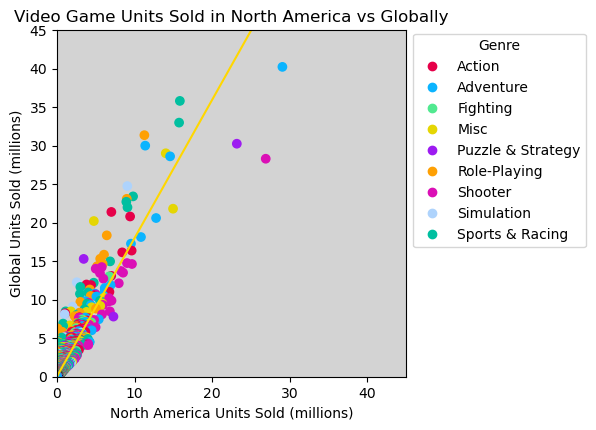

In [20]:
#correlation for NA vs Global
corr = round(st.pearsonr(sales_data_clean["NA_Sales"], sales_data_clean["Global_Sales"])[0],2)
print(f"The correlation between North American Sales and Global Sales is {corr}.")

#regression for NA vs Global
x_values = sales_data_clean["NA_Sales"]
y_values = sales_data_clean["Global_Sales"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = f"Linear Regression Model: y = {round(slope,2)} x + {round(intercept,2)}"
print(line_eq)

#Plot
fig, ax = plt.subplots(figsize=(4.5, 4.5),facecolor="#FFFFFF")
ax.set_facecolor("lightgrey")
scatter = ax.scatter(x_values, y_values, c = sales_data_clean.Genre.astype('category').cat.codes, cmap=full_genre)

#Regression Line
plt.xlim([0,45])
plt.ylim([0,45])
line2, = ax.plot(x_values,regress_values, "gold")

#legend
leg2 = ax.legend(handles=scatter.legend_elements()[0], labels = genre_name, title="Genre",bbox_to_anchor=(1, 1.01))

plt.title("Video Game Units Sold in North America vs Globally")
plt.xlabel("North America Units Sold (millions)")
plt.ylabel("Global Units Sold (millions)")
plt.show()

In [21]:
#Regression Results from the table
x1 = rpg["NA_Sales"]
y1 = rpg["Global_Sales"]
X = sm.add_constant(x1)
model = sm.OLS(y1, X).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                 1.028e+04
Date:                Tue, 23 May 2023   Prob (F-statistic):               0.00
Time:                        18:14:54   Log-Likelihood:                -1314.7
No. Observations:                1429   AIC:                             2633.
Df Residuals:                    1427   BIC:                             2644.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1005      0.017      5.931      0.0

In [22]:
### North America vs Japan

The correlation is 0.45.
Linear Regression Model: y = 0.17 x + 0.03


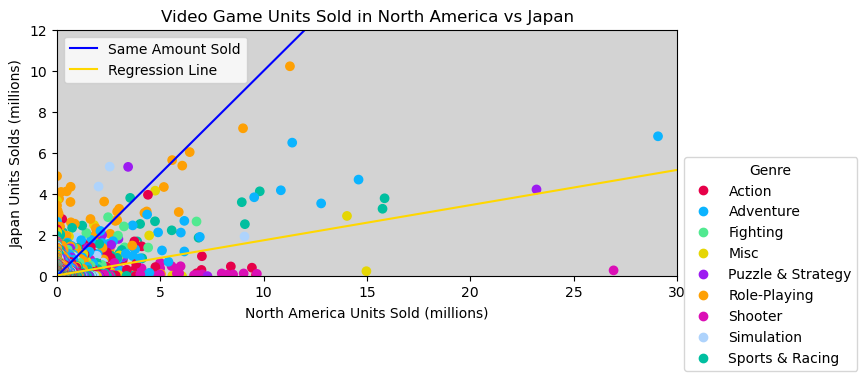

In [23]:
#correlation for NA vs JP
corr = round(st.pearsonr(sales_data_clean["NA_Sales"], sales_data_clean["JP_Sales"])[0],2)
print(f"The correlation is {corr}.")

#regression for NA vs JP
x_values = sales_data_clean["NA_Sales"]
y_values = sales_data_clean["JP_Sales"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = f"Linear Regression Model: y = {round(slope,2)} x + {round(intercept,2)}"
print(line_eq)

#Plot
fig, ax = plt.subplots(figsize=(8, 3.2),facecolor="#FFFFFF")
ax.set_facecolor("lightgrey")
scatter = ax.scatter(x_values, y_values, c = sales_data_clean.Genre.astype('category').cat.codes, cmap=full_genre)

#Equal Sales Line
x = np.linspace(0,30,30)
y = x
line1, = ax.plot(x,y, color="blue")

#Regression Line
plt.xlim([0,30])
plt.ylim([0,12])
line2, = ax.plot(x_values,regress_values, "gold")

#legends
leg1 = ax.legend(handles=[line1, line2],labels=["Same Amount Sold","Regression Line"], loc="upper left")
leg2 = ax.legend(handles=scatter.legend_elements()[0], labels = genre_name, title="Genre", bbox_to_anchor=(1,.51))
ax.add_artist(leg1)

plt.title("Video Game Units Sold in North America vs Japan")
plt.xlabel("North America Units Sold (millions)")
plt.ylabel("Japan Units Solds (millions)")

plt.show()

In [24]:
#Regression Results from the table
x1 = sales_data_clean["NA_Sales"]
y1 = sales_data_clean["JP_Sales"]
X = sm.add_constant(x1)
model = sm.OLS(y1, X).fit()
print_model = model.summary()

print(print_model)

                            OLS Regression Results                            
Dep. Variable:               JP_Sales   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     4094.
Date:                Tue, 23 May 2023   Prob (F-statistic):               0.00
Time:                        18:14:56   Log-Likelihood:                -2368.1
No. Observations:               15979   AIC:                             4740.
Df Residuals:                   15977   BIC:                             4756.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0333      0.002     14.273      0.0

The correlation is 0.63.


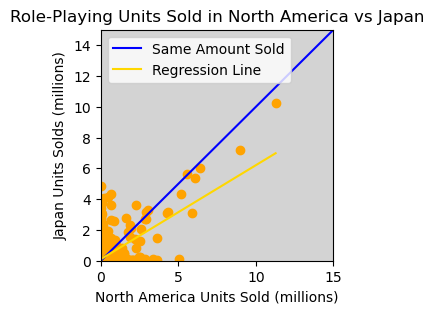

In [25]:
#correlation for NA vs JP - RPG
corr = round(st.pearsonr(rpg["NA_Sales"], rpg["JP_Sales"])[0],2)
print(f"The correlation is {corr}.")

#regression for NA vs JP - RPG
x_values = rpg["NA_Sales"]
y_values = rpg["JP_Sales"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = f"Linear Regression Model: y = {round(slope,2)} x + {round(intercept,2)}"

#Plot
fig, ax = plt.subplots(figsize=(3, 3),facecolor="#FFFFFF")
ax.set_facecolor("lightgrey")
scatter = ax.scatter(x_values, y_values, c="#ffa300")

#Equal Sales Line
x = np.linspace(0,100,100)
y = x
line1, = ax.plot(x,y, color="blue")

#Regression Line
plt.xlim([0,15])
plt.ylim([0,15])
line2, = ax.plot(x_values,regress_values, "gold")

#Legend
leg1 = ax.legend(handles=[line1, line2],labels=["Same Amount Sold","Regression Line"], loc="upper left")

plt.title("Role-Playing Units Sold in North America vs Japan")
plt.xlabel("North America Units Sold (millions)")
plt.ylabel("Japan Units Solds (millions)")
plt.show()
plt.show()

In [26]:
#identify specific games
rpg_out = rpg.loc[(rpg["JP_Sales"]>3) & (rpg["NA_Sales"]>3)]
rpg_out.head(20)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform Company
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,Nintendo
12,Pokemon Gold/Pokemon Silver,GB,1999,Role-Playing,Nintendo,9.00,6.18,7.20,0.71,23.10,Nintendo
20,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,Nintendo,6.42,4.52,6.04,1.37,18.36,Nintendo
25,Pokemon Ruby/Pokemon Sapphire,GBA,2002,Role-Playing,Nintendo,6.06,3.90,5.38,0.50,15.85,Nintendo
26,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5.57,3.28,5.65,0.82,15.32,Nintendo
30,Pokémon Yellow: Special Pikachu Edition,GB,1998,Role-Playing,Nintendo,5.89,5.04,3.12,0.59,14.64,Nintendo
32,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,Nintendo,5.17,4.05,4.34,0.79,14.35,Nintendo
49,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,Nintendo,4.23,3.37,3.08,0.65,11.33,Nintendo
58,Pokemon FireRed/Pokemon LeafGreen,GBA,2004,Role-Playing,Nintendo,4.34,2.65,3.15,0.35,10.49,Nintendo
66,Final Fantasy VII,PS,1997,Role-Playing,Sony Computer Entertainment,3.01,2.47,3.28,0.96,9.72,Sony


In [27]:
#Regression Results from the table
x1 = rpg["NA_Sales"]
y1 = rpg["JP_Sales"]
X = sm.add_constant(x1)
model = sm.OLS(y1, X).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               JP_Sales   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     959.3
Date:                Tue, 23 May 2023   Prob (F-statistic):          1.59e-161
Time:                        18:14:57   Log-Likelihood:                -1064.9
No. Observations:                1429   AIC:                             2134.
Df Residuals:                    1427   BIC:                             2144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1037      0.014      7.294      0.0

The correlation is 0.22.


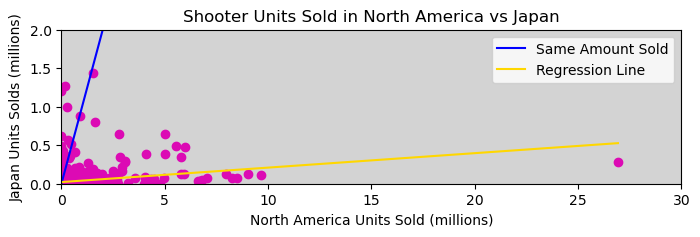

In [28]:
#correlation for NA vs JP - Shooter
corr = round(st.pearsonr(shooter["NA_Sales"], shooter["JP_Sales"])[0],2)
print(f"The correlation is {corr}.")

#regression for NA vs JP - Shooter
x_values = shooter["NA_Sales"]
y_values = shooter["JP_Sales"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = f"Linear Regression Model: y = {round(slope,2)} x + {round(intercept,2)}"

#Plot
fig, ax = plt.subplots(figsize=(8, 2),facecolor="#FFFFFF")
ax.set_facecolor("lightgrey")
scatter = ax.scatter(x_values, y_values, c="#dc0ab4")

#Equal Sales Line
x = np.linspace(0,100,100)
y = x
line1, = ax.plot(x,y, color="blue")

#Regression Line
plt.xlim([0,30])
plt.ylim([0,2])
line2, = ax.plot(x_values,regress_values, "gold")

#Legend
leg1 = ax.legend(handles=[line1, line2],labels=["Same Amount Sold","Regression Line"], loc="upper right")

plt.title("Shooter Units Sold in North America vs Japan")
plt.xlabel("North America Units Sold (millions)")
plt.ylabel("Japan Units Solds (millions)")
plt.show()

In [29]:
#identify specific games
shooter_out = shooter.loc[shooter["JP_Sales"]>.75]
shooter_out

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform Company
235,Splatoon,WiiU,2015,Shooter,Nintendo,1.55,1.15,1.44,0.43,4.57,Nintendo
438,Resident Evil 6,PS3,2012,Shooter,Capcom,0.88,0.97,0.88,0.42,3.15,Sony
472,Star Fox,SNES,1993,Shooter,Nintendo,1.61,0.51,0.80,0.07,2.99,Nintendo
1234,Xevious,NES,1984,Shooter,Namco Bandai Games,0.18,0.06,1.27,0.01,1.52,Nintendo
1427,Gradius,NES,1986,Shooter,Konami Digital Entertainment,0.27,0.08,1.00,0.01,1.36,Nintendo
1675,TwinBee,NES,1986,Shooter,Konami Digital Entertainment,0.00,0.00,1.20,0.00,1.20,Nintendo


In [30]:
#identify specific games
shooter_out = shooter.loc[shooter["NA_Sales"]>4.75]
shooter_out

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform Company
9,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31,Nintendo
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76,Microsoft
31,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9.67,3.73,0.11,1.13,14.64,Microsoft
33,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24,Sony
34,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.03,Sony
35,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.73,Microsoft
36,Call of Duty: Modern Warfare 2,X360,2009,Shooter,Activision,8.52,3.63,0.08,1.29,13.51,Microsoft
37,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5.54,5.82,0.49,1.62,13.46,Sony
40,Call of Duty: Black Ops,PS3,2010,Shooter,Activision,5.98,4.44,0.48,1.83,12.73,Sony
43,Halo 3,X360,2007,Shooter,Microsoft Game Studios,7.97,2.83,0.13,1.21,12.14,Microsoft


In [31]:
#Regression Results from the table
x1 = shooter["NA_Sales"]
y1 = shooter["JP_Sales"]
X = sm.add_constant(x1)
model = sm.OLS(y1, X).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               JP_Sales   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     63.55
Date:                Tue, 23 May 2023   Prob (F-statistic):           3.51e-15
Time:                        18:14:57   Log-Likelihood:                 1081.5
No. Observations:                1250   AIC:                            -2159.
Df Residuals:                    1248   BIC:                            -2149.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0215      0.003      7.002      0.0

The correlation is 0.54.


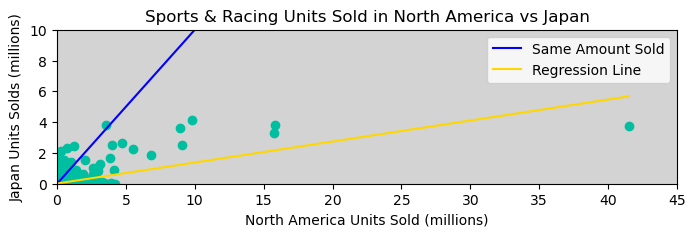

In [32]:
#correlation for NA vs JP - Sports and Racing
corr = round(st.pearsonr(sports["NA_Sales"], sports["JP_Sales"])[0],2)
print(f"The correlation is {corr}.")

#regression for NA vs JP - Sports and Racing
x_values = sports["NA_Sales"]
y_values = sports["JP_Sales"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = f"Linear Regression Model: y = {round(slope,2)} x + {round(intercept,2)}"

#Plot
fig, ax = plt.subplots(figsize=(8, 2),facecolor="#FFFFFF")
ax.set_facecolor("lightgrey")
scatter = ax.scatter(x_values, y_values, c="#00bfa0")

#Equal Sales Line
x = np.linspace(0,100,100)
y = x
line1, = ax.plot(x,y, color="blue")

#Regression Line
plt.xlim([0,45])
plt.ylim([0,10])
line2, = ax.plot(x_values,regress_values, "gold")

#Legend
leg1 = ax.legend(handles=[line1, line2],labels=["Same Amount Sold","Regression Line"], loc="upper right")

plt.title("Sports & Racing Units Sold in North America vs Japan")
plt.xlabel("North America Units Sold (millions)")
plt.ylabel("Japan Units Solds (millions)")
plt.show()

In [33]:
#identify specific games
sports_out = sports.loc[(sports["JP_Sales"]>1) & (sports["NA_Sales"]>3)]
sports_out

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform Company
0,Wii Sports,Wii,2006,Sports & Racing,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo
2,Mario Kart Wii,Wii,2008,Sports & Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Nintendo
3,Wii Sports Resort,Wii,2009,Sports & Racing,Nintendo,15.75,11.01,3.28,2.96,33.00,Nintendo
11,Mario Kart DS,DS,2005,Sports & Racing,Nintendo,9.81,7.57,4.13,1.92,23.42,Nintendo
13,Wii Fit,Wii,2007,Sports & Racing,Nintendo,8.94,8.03,3.60,2.15,22.72,Nintendo
14,Wii Fit Plus,Wii,2009,Sports & Racing,Nintendo,9.09,8.59,2.53,1.79,22.00,Nintendo
28,Gran Turismo 3: A-Spec,PS2,2001,Sports & Racing,Sony Computer Entertainment,6.85,5.09,1.87,1.16,14.98,Sony
42,Mario Kart 7,3DS,2011,Sports & Racing,Nintendo,4.74,3.91,2.67,0.89,12.21,Nintendo
47,Gran Turismo 4,PS2,2004,Sports & Racing,Sony Computer Entertainment,3.01,0.01,1.10,7.53,11.66,Sony
52,Gran Turismo,PS,1997,Sports & Racing,Sony Computer Entertainment,4.02,3.87,2.54,0.52,10.95,Sony


In [34]:
#Regression Results from the table
x1 = sports["NA_Sales"]
y1 = sports["JP_Sales"]
X = sm.add_constant(x1)
model = sm.OLS(y1, X).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               JP_Sales   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     1414.
Date:                Tue, 23 May 2023   Prob (F-statistic):          6.34e-260
Time:                        18:14:58   Log-Likelihood:                 572.37
No. Observations:                3472   AIC:                            -1141.
Df Residuals:                    3470   BIC:                            -1128.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0148      0.004      4.049      0.0

In [35]:
## North America vs EU

The correlation is 0.77.
Linear Regression Model: y = 0.48 x + 0.02


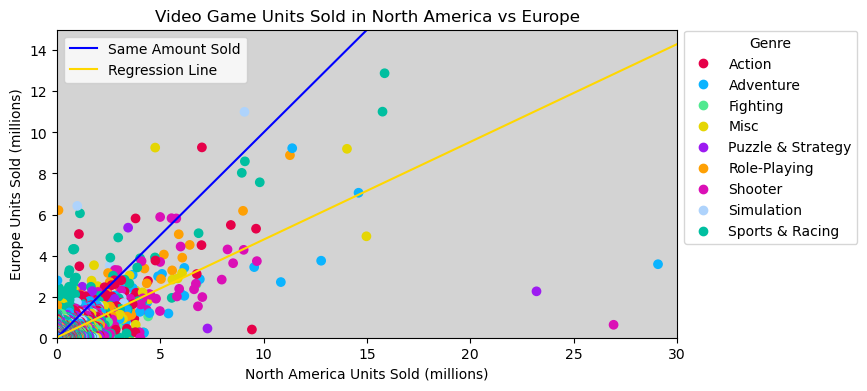

In [36]:
#correlation for NA vs EU
corr = round(st.pearsonr(sales_data_clean["NA_Sales"], sales_data_clean["EU_Sales"])[0],2)
print(f"The correlation is {corr}.")

#regression for NA vs EU
x_values = sales_data_clean["NA_Sales"]
y_values = sales_data_clean["EU_Sales"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = f"Linear Regression Model: y = {round(slope,2)} x + {round(intercept,2)}"
print(line_eq)

#Plot
fig, ax = plt.subplots(figsize=(8, 4),facecolor="#FFFFFF")
ax.set_facecolor("lightgrey")
scatter = ax.scatter(x_values, y_values, c = sales_data_clean.Genre.astype('category').cat.codes, cmap=full_genre)

#Equal Sales Line
x = np.linspace(0,100,100)
y = x
line1, = ax.plot(x,y, color="blue")

#Regression Line
plt.xlim([0,30])
plt.ylim([0,15])
line2, = ax.plot(x_values,regress_values, "gold")

#Legends
leg1 = ax.legend(handles=[line1, line2],labels=["Same Amount Sold","Regression Line"], loc="upper left")
leg2 = ax.legend(handles=scatter.legend_elements()[0], labels = genre_name, title="Genre", bbox_to_anchor=(1, 1.02))
ax.add_artist(leg1)

plt.title("Video Game Units Sold in North America vs Europe")
plt.xlabel("North America Units Sold (millions)")
plt.ylabel("Europe Units Sold (millions)")
plt.show()

In [37]:
#Regression Results from the table
x1 = sales_data_clean["NA_Sales"]
y1 = sales_data_clean["EU_Sales"]
X = sm.add_constant(x1)
model = sm.OLS(y1, X).fit()
print_model = model.summary()

print(print_model)

                            OLS Regression Results                            
Dep. Variable:               EU_Sales   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                 2.331e+04
Date:                Tue, 23 May 2023   Prob (F-statistic):               0.00
Time:                        18:15:00   Log-Likelihood:                -4805.2
No. Observations:               15979   AIC:                             9614.
Df Residuals:                   15977   BIC:                             9630.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0207      0.003      7.616      0.0

The correlation is 0.88.


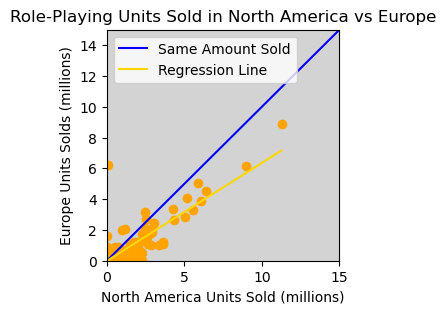

In [38]:
#correlation for NA vs EU - RPG
corr = round(st.pearsonr(rpg["NA_Sales"], rpg["EU_Sales"])[0],2)
print(f"The correlation is {corr}.")

#regression for NA vs EU - RPG
x_values = rpg["NA_Sales"]
y_values = rpg["EU_Sales"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = f"Linear Regression Model: y = {round(slope,2)} x + {round(intercept,2)}"

#Plot
fig, ax = plt.subplots(figsize=(3, 3),facecolor="#FFFFFF")
ax.set_facecolor("lightgrey")
scatter = ax.scatter(x_values, y_values, c="#ffa300")

#Equal Sales Line
x = np.linspace(0,100,100)
y = x
line1, = ax.plot(x,y, color="blue")

#Regression Line
plt.xlim([0,15])
plt.ylim([0,15])
line2, = ax.plot(x_values,regress_values, "gold")

#Legend
leg1 = ax.legend(handles=[line1, line2],labels=["Same Amount Sold","Regression Line"], loc="upper left")

plt.title("Role-Playing Units Sold in North America vs Europe")
plt.xlabel("North America Units Sold (millions)")
plt.ylabel("Europe Units Solds (millions)")

plt.show()

In [39]:
#identify specific games
rpg_out = rpg.loc[(rpg["NA_Sales"]>4) & (rpg["EU_Sales"]>4)]
rpg_out

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform Company
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,Nintendo
12,Pokemon Gold/Pokemon Silver,GB,1999,Role-Playing,Nintendo,9.00,6.18,7.20,0.71,23.10,Nintendo
20,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,Nintendo,6.42,4.52,6.04,1.37,18.36,Nintendo
30,Pokémon Yellow: Special Pikachu Edition,GB,1998,Role-Playing,Nintendo,5.89,5.04,3.12,0.59,14.64,Nintendo
32,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,Nintendo,5.17,4.05,4.34,0.79,14.35,Nintendo


In [40]:
#Regression Results from the table
x1 = rpg["NA_Sales"]
y1 = rpg["EU_Sales"]
X = sm.add_constant(x1)
model = sm.OLS(y1, X).fit()
print_model = model.summary()

print(print_model)

                            OLS Regression Results                            
Dep. Variable:               EU_Sales   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     4690.
Date:                Tue, 23 May 2023   Prob (F-statistic):               0.00
Time:                        18:15:01   Log-Likelihood:                 8.3539
No. Observations:                1429   AIC:                            -12.71
Df Residuals:                    1427   BIC:                            -2.178
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0145      0.007     -2.162      0.0

The correlation is 0.67.


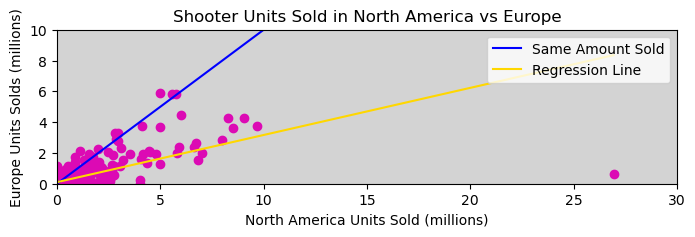

In [41]:
#correlation for NA vs EU - Shooter
corr = round(st.pearsonr(shooter["NA_Sales"], shooter["EU_Sales"])[0],2)
print(f"The correlation is {corr}.")

#regression for NA vs EU - Shooter
x_values = shooter["NA_Sales"]
y_values = shooter["EU_Sales"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = f"Linear Regression Model: y = {round(slope,2)} x + {round(intercept,2)}"

#Plot
fig, ax = plt.subplots(figsize=(8, 2),facecolor="#FFFFFF")
ax.set_facecolor("lightgrey")
scatter = ax.scatter(x_values, y_values, c="#dc0ab4")

#Equal Sales Line
x = np.linspace(0,100,100)
y = x
line1, = ax.plot(x,y, color="blue")

#Regression Line
plt.xlim([0,30])
plt.ylim([0,10])
line2, = ax.plot(x_values,regress_values, "gold")

#Legend
leg1 = ax.legend(handles=[line1, line2],labels=["Same Amount Sold","Regression Line"], loc="upper right")

plt.title("Shooter Units Sold in North America vs Europe")
plt.xlabel("North America Units Sold (millions)")
plt.ylabel("Europe Units Solds (millions)")
plt.show()

In [42]:
#identify specific games
shooter_out = shooter.loc[(shooter["NA_Sales"]>4) & (shooter["EU_Sales"]>4)]
shooter_out

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform Company
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76,Microsoft
33,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24,Sony
34,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.03,Sony
35,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.73,Microsoft
37,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5.54,5.82,0.49,1.62,13.46,Sony
40,Call of Duty: Black Ops,PS3,2010,Shooter,Activision,5.98,4.44,0.48,1.83,12.73,Sony


In [43]:
#Regression Results from the table
x1 = shooter["NA_Sales"]
y1 = shooter["EU_Sales"]
X = sm.add_constant(x1)
model = sm.OLS(y1, X).fit()
print_model = model.summary()

print(print_model)

                            OLS Regression Results                            
Dep. Variable:               EU_Sales   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     1042.
Date:                Tue, 23 May 2023   Prob (F-statistic):          1.19e-166
Time:                        18:15:02   Log-Likelihood:                -660.66
No. Observations:                1250   AIC:                             1325.
Df Residuals:                    1248   BIC:                             1336.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1031      0.012      8.323      0.0

The correlation is 0.87.


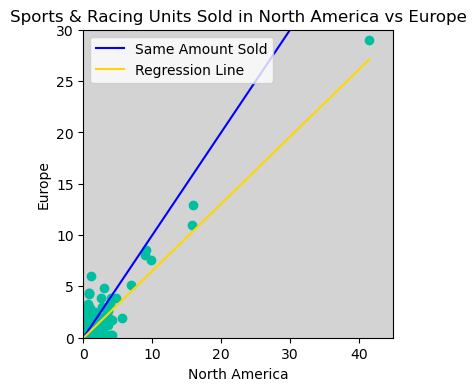

In [44]:
#correlation for NA vs EU - Sports & Racing
corr = round(st.pearsonr(sports["NA_Sales"], sports["EU_Sales"])[0],2)
print(f"The correlation is {corr}.")

#regression for NA vs EU - Sports & Racing
x_values = sports["NA_Sales"]
y_values = sports["EU_Sales"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = f"Linear Regression Model: y = {round(slope,2)} x + {round(intercept,2)}"

#Plot
fig, ax = plt.subplots(figsize=(4, 4),facecolor="#FFFFFF")
ax.set_facecolor("lightgrey")
scatter = ax.scatter(x_values, y_values, c="#00bfa0")

#Equal Sales Line
x = np.linspace(0,100,100)
y = x
line1, = ax.plot(x,y, color="blue")

#Regression Line
plt.xlim([0,45])
plt.ylim([0,30])
line2, = ax.plot(x_values,regress_values, "gold")

#Legend
leg1 = ax.legend(handles=[line1, line2],labels=["Same Amount Sold","Regression Line"], loc="upper left")

plt.title("Sports & Racing Units Sold in North America vs Europe")
plt.xlabel("North America")
plt.ylabel("Europe")
plt.show()

In [45]:
#identify specific games
sports_out = sports.loc[(sports["EU_Sales"]>5) & (sports["NA_Sales"]>5)]
sports_out

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform Company
0,Wii Sports,Wii,2006,Sports & Racing,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo
2,Mario Kart Wii,Wii,2008,Sports & Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Nintendo
3,Wii Sports Resort,Wii,2009,Sports & Racing,Nintendo,15.75,11.01,3.28,2.96,33.00,Nintendo
11,Mario Kart DS,DS,2005,Sports & Racing,Nintendo,9.81,7.57,4.13,1.92,23.42,Nintendo
13,Wii Fit,Wii,2007,Sports & Racing,Nintendo,8.94,8.03,3.60,2.15,22.72,Nintendo
14,Wii Fit Plus,Wii,2009,Sports & Racing,Nintendo,9.09,8.59,2.53,1.79,22.00,Nintendo
28,Gran Turismo 3: A-Spec,PS2,2001,Sports & Racing,Sony Computer Entertainment,6.85,5.09,1.87,1.16,14.98,Sony


In [46]:
#Regression Results from the table
x1 = sports["NA_Sales"]
y1 = sports["EU_Sales"]
X = sm.add_constant(x1)
model = sm.OLS(y1, X).fit()
print_model = model.summary()

print(print_model)

                            OLS Regression Results                            
Dep. Variable:               EU_Sales   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                 1.064e+04
Date:                Tue, 23 May 2023   Prob (F-statistic):               0.00
Time:                        18:15:02   Log-Likelihood:                -1365.8
No. Observations:                3472   AIC:                             2736.
Df Residuals:                    3470   BIC:                             2748.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0199      0.006     -3.118      0.0

In [47]:
## Correlation and Heat Map

In [48]:
sales_data_clean.corr()

C:\Users\rajag\AppData\Local\Temp\ipykernel_30356\3302601761.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sales_data_clean.corr()


,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Year,1.000000,-0.085347,0.011394,-0.170121,0.047488,-0.069223
NA_Sales,-0.085347,1.000000,0.770262,0.451618,0.634225,0.941499
EU_Sales,0.011394,0.770262,1.000000,0.437859,0.725572,0.903753
JP_Sales,-0.170121,0.451618,0.437859,1.000000,0.290955,0.613358
Other_Sales,0.047488,0.634225,0.725572,0.290955,1.000000,0.747362
Global_Sales,-0.069223,0.941499,0.903753,0.613358,0.747362,1.000000


C:\Users\rajag\AppData\Local\Temp\ipykernel_30356\229655016.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = sales_data_clean.corr()


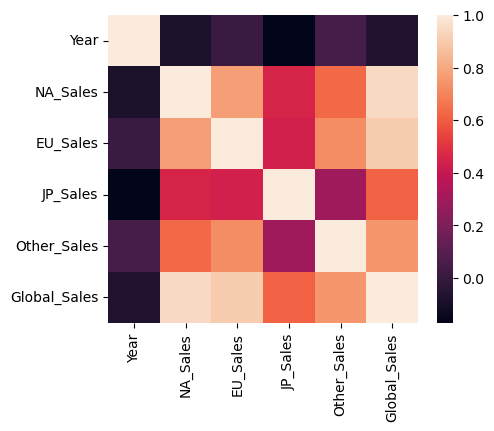

In [49]:
corr = sales_data_clean.corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr)
plt.show()

In [50]:
## T-Test

In [51]:
#ttest calculations
pop_x = shooter.EU_Sales
pop_y = sports.EU_Sales
print(pop_x.mean())
print(pop_x.var())
print(len(pop_x))
print(pop_y.mean())
print(pop_y.var())
print(len(pop_y))
st.ttest_ind(pop_x.values, pop_y.values, equal_var=False)

0.2422
0.3093768214571657
1250
0.17256912442396313
0.5231511044109045
3472


Ttest_indResult(statistic=3.489497475688349, pvalue=0.0004912614990934529)